# Web Scraping & Predicting

In this project, we will practice two major skills. Collecting data by scraping a website and building a binary predictor with Logistic Regression.

## Yelp data web-scraping: Research on Sushi Restaurants in Bellevue, WA

### Project Goal: Predict customer's attitude toward a restaurant based on the content of his/her review

### Bag of Words Approach: 
features: binary variables of the occurrence of key words conveying positive and negative sentiments

response variable: 
       Binary variable of customer's attitude toward a restaurant (positive or negative), together with Probability of a review is positive

### Model Accuracy:

In [62]:
#                  precision    recall  f1-score   support        

              0       0.58      0.34      0.43        62
              1       0.86      0.95      0.90       276

#   avg / total       0.81      0.83      0.82       338

### Step 1: Scrape your site

We will be scraping your website using BeautifulSoup. Write your code below.

In [1]:
import urllib2
from bs4 import BeautifulSoup
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Yelp Page Scraping
url = 'https://www.yelp.com/search?find_desc=sushi&find_loc=Bellevue,+WA'
base = 'https://www.yelp.com'

# Retrieve the Name, Address and URL of each restaurant that we are interested in from Yelp 
restaurantsDict = {
    'name':[],
    'url':[],
    'address':[]
}

stepList = map(str, range(0, 60, 10)) 
 
for step in stepList:
    if step == '':
         r = requests.get(url)
    else: 
        r = requests.get(url+'&start='+ str(step))
        
    # Convert the content into a usable format
    soup = BeautifulSoup(r.content, "lxml")  

    for (idx, data) in enumerate(soup.find_all(["div"], {"class":"media-story"})):
        if idx > 1:
            for content in data.find_all(["p"], {"class":"snippet"}):
                for link in content.find_all("a"):
                    restaurantsDict['url'] += [base + link['href']]
            for content in data.find_all(["a"], {"data-analytics-label":"biz-name"}):
                restaurantsDict['name'] += [content.text] 
            
    for (idy, data) in enumerate(soup.find_all(["div"], {"class":"secondary-attributes"})):
        if idy > 0:
            for content in data.find_all(["address"]):
                restaurantsDict['address'] += [content.text.replace("\n", "").strip()]

# Save the Restaurants Info in the following data frame, add restaurant ID
restaurantsDF = pd.DataFrame(restaurantsDict)
restaurantsDF['id'] = restaurantsDF.index + 1

### Write functions to extract the features you think correlate well with your dataset. You MUST have at least 4 features!

- **Make sure these functions are robust and can handle cases where fields may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it
    - Remember to use `try/except` if you anticipate errors
- **Test** the functions on the results above and simple examples

In [87]:
# Retrieve most recent 20 reviews for each restaurant (date, rating, review content)

for i in restaurantsDF['id'].values:
    try:
#         filename = "review" + str(i) + ".txt"
#         f = open(filename,'w')
        data = {
            'review':[],
            'rating':[],
            'date':[], 
            'id':[]
            }

        r = requests.get(restaurantsDF['url'][i-1])
        soup = BeautifulSoup(r.content, "lxml")  
        
        for (idx, data) in enumerate(soup.find_all(["div"], {"class":"review-content"})):
            
            # find the rating
            for rating in data.find_all(["div"], {"class":"rating-very-large"}):
                data['ratings'] += [int(rating.find_all("i")[0]["class"][1][-1])]
#                 print int(rating.find_all("i")[0]["class"][1][-1])
#                 f.write(str(rating.find_all("i")[0]["class"][1][-1]))
#                 f.write("\n")
                pass

            # find review
            for review in data.find_all("p"):
                data['reviews'] += [review.text]
#                 print review.text
#                 f.write(review.text.encode('utf-8'))
#                 f.write("\n")
                pass
            
            # find rating date
            for date in data.find_all("span", {"class":"rating-qualifier"}):
                print date.text.strip()[0:10].replace(" ","").replace("\n", "")
#                 data['dates'] += [date.text.strip()[0:10].replace(" ","").replace("\n", "")]
#                 f.write(date.text.strip()[0:10].replace(" ","").replace("\n", ""))
#                 f.write("\n")
                pass
        f.close() 
   
    except Exception as e:
        print i,":", e

1 : 'ratings'
2 : 'ratings'
3 : 'ratings'
4 : 'ratings'
5 : 'ratings'
6 : 'ratings'
7 : 'ratings'
8 : 'ratings'
9 : 'ratings'
10 : 'ratings'
11 : 'ratings'
12 : 'ratings'
13 : 'ratings'
14 : 'ratings'
15 : 'ratings'
16 : 'ratings'
17 : 'ratings'
18 : 'ratings'


KeyboardInterrupt: 

### Make sure you have at least 1000 rows before continuing.

#### Clean up / standardize your data here

- Dates converted to correct format
- Remove dollar signs, spaces, periods
- etc

### Create a dataframe to compile the results of your data cleaning.

In [12]:
# Read all the scraped data from txt files into a list of data frames: RestaurantList
RestaurantList = []

for y in restaurantsDF['id'].values:
    data = {
            'review':[],
            'rating':[],
            'date':[], 
            'id':[]
            }
    filename = 'review' + str(y) + '.txt'
    text_file = open(filename, "r")
    lines = text_file.readlines()
    for i in range(0, len(lines)):
        if (i%3 == 0):
            data['rating'] += [int(lines[i].replace("\n", ""))]
        elif i%3 == 1:
            data['review'] += [lines[i].replace("\n", "")]
        else:
            data['date'] += [lines[i].replace("\n", "")]
    data['id'] = y
    text_file.close()
    RestaurantList += [pd.DataFrame(data)]
    
# Combine all the review data into one data frame ReviewsDF
ReviewsDF = pd.DataFrame(columns = RestaurantList[0].columns.values)
for i in range(0, len(RestaurantList)):
    ReviewsDF = pd.concat((ReviewsDF, RestaurantList[i]), axis = 0)

# Join the Reviews dataframe and Restaurants Data Frame together by Restaurant ID
dataDF = pd.merge(ReviewsDF, restaurantsDF, on = 'id', how = 'inner')
columnsSorted = ['id', 'name', 'url', 'address', 'rating', 'date', 'review']
dataDF = dataDF[columnsSorted]

dataDF['date'] = pd.to_datetime(dataDF["date"], format="%m/%d/%Y")
dataDF['year'] = dataDF['date'].dt.year
dataDF['month'] = dataDF['date'].dt.month

In [13]:
# Make sure our dataset has more than 1000 rows
print len(dataDF)

1216


## Exploratory Data Analysis

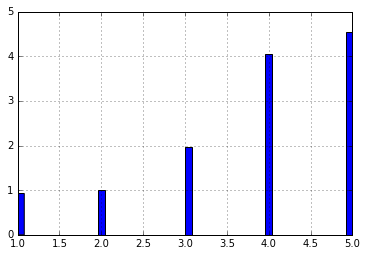

In [14]:
# distribution of ratings
# customers tend to leave more positive reviews 
dataDF['rating'].hist(cumulative=False, normed=1, bins=50)

In [15]:
# Find the Top 10 best rated Sushi places
pd.pivot_table(dataDF, index = ['name', 'address'], values = ['rating'], aggfunc = np.mean).sort_values(by = 'rating', ascending = False)[0:10]

,,rating
name,address,
Sushi Kashiba,"86 Pine StSeattle, WA 98101",4.650000
Wataru,"2400 NE 65th St.Seattle, WA 98115",4.619048
Aji Sushi & Grill,"1052 NE Park DrIssaquah, WA 98029",4.571429
Rolls and Rolls Plus Sushi,"11011 NE 12th StBellevue, WA 98004",4.500000
Musashi’s,"3720 Factoria Blvd SEBellevue, WA 98006",4.476190
Sandwich House Tres,"1502 145th Pl SEBellevue, WA 98007",4.428571
Market Fresh,"601 108th Ave NEBellevue, WA 98004",4.380952
Maneki,"304 6th Ave SSeattle, WA 98104",4.350000
Suika Seattle,"611 E Pine StSeattle, WA 98122",4.350000


In [83]:
# The response variable column seems quite biased
dataDF['sentiment'].value_counts()/len(dataDF['sentiment'])

1    0.816406
0    0.183594
Name: sentiment, dtype: float64

### Manipulate the Data for Modeling

In [16]:
# Neutral Ratings is boring, drop them all
dataDF = dataDF.dropna()
dataDF = dataDF[dataDF['rating'] != 3]

In [17]:
## Backup my data frame
dataDFBackup = dataDF

In [18]:
dataDF = dataDFBackup

In [19]:
# Assign the sentiment lable column: 1 if the rating is higher than 3 and 0 if less than 3
dataDF['sentiment'] = pd.Series([1 if x >= 4 else 0 for x in dataDF['rating']], index = dataDF.index)

In [20]:
# Build a word_count function that counts the non-trivial words in each review
import re
rejects = ['the','and','to','a','this','is','on','has','new','in', 'there', 'here', 'had', 'food', 'sushi',
           'it', 'have', 'was','but','i','about','be','not','if','at', 'we', 'you', 'your', 'they', 'my', 
           'its', 'it\'s', 'our', 'which', 'also', 'their', 'when', 'some',
           'an','of','that','by','from','as','with','for','are','were','or', '\xc2\xa0', 'sushi', 'time'
          ]

rejects += [str(x) for x in range(10)]

def replaceText(stringy):
    if stringy.__class__.__name__ in  ['str', 'unicode']:
        new_stringy = re.sub("[^0-9a-zA-Z']", "",stringy)
        if not new_stringy:
            return ''
        return str(new_stringy)
    return stringy

def word_counts(text):
    a =  ' '.join([replaceText(item).lower() for item in text.split(" ") if (replaceText(item)!='') & ( len(replaceText(item))!=1 )]).strip()
    if a!= "":
        return pd.Series(a.split(" ")).value_counts().to_dict()
    else:
        return {}
    
def word_non_trivial_counts(text):
    a =  ' '.join([replaceText(item).lower() for item in text.split(" ") if ( replaceText(item).lower() not in rejects) & (replaceText(item)!='') & ( len(replaceText(item))!=1 )]).strip()
    if a!= "":
        return pd.Series(a.split(" ")).value_counts().to_dict()
    else:
        return {}

In [21]:
# Identify the positive and negative keywords as features
positiveReviews = ' '.join([x for x in dataDF[dataDF['rating'] >= 4]['review'] ])
negativeReviews = ' '.join([x for x in dataDF[dataDF['rating'] <= 2]['review'] ])

positiveReviewWordCount = pd.Series(word_non_trivial_counts(positiveReviews)).sort_values(ascending = False)
negativeReviewWordCount = pd.Series(word_non_trivial_counts(negativeReviews)).sort_values(ascending = False)

f = open('PositiveCounts.txt','w')
for index, value in positiveReviewWordCount.iteritems():
    f.write(str(index) + "," + str(value) + "\n")
f.close()

f = open('NegativeCounts.txt','w')
for index, value in negativeReviewWordCount.iteritems():
    f.write(str(index) + "," + str(value) + "\n")
f.close()

In [22]:
# Identify the keywords for feature selection
# I eyeballed the two output files and decided on the following keywords
negatives = ['don\'t', 'too', 'even', 'no', 'never', 'sad', 'bad', 'wasn\'t']
positives = ['good', 'great', 'like', 'love', 'happy', 'favorite']

In [23]:
# add a word count column for each review
dataDF['word_counts'] = pd.Series([word_counts(x) for x in dataDF['review']], index = dataDF.index)

In [85]:
dataDF[['review', 'word_counts']].head(2)

,review,word_counts
0,This place has the b st sushi for the price. ...,"{u'just': 1, u'grade': 1, u'is': 1, u'sushi': ..."
1,fresh food and good deal sushi! Chirashi bowl ...,"{u'and': 2, u'want': 1, u'deal': 1, u'is': 1, ..."


In [24]:
# Add dummy variable columns as features
for pos in positives:
    dataDF[pos] = pd.Series([1 if pos in x.keys() else 0 for x in dataDF['word_counts']], index = dataDF.index)
for neg in negatives:
    dataDF[neg] = pd.Series([1 if neg in x.keys() else 0 for x in dataDF['word_counts']], index = dataDF.index)
    
# Add year and month as features as well
for year in dataDF['year']:
    dataDF[str(year)] = pd.Series([1 if x == year else 0 for x in dataDF['year']], index = dataDF.index)
for month in dataDF['month']:
    dataDF[str(month)] = pd.Series([1 if x == month else 0 for x in dataDF['month']], index = dataDF.index)

## Logistic Regression Models

### import packages

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm

C:\Users\jason\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\jason\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Option 1: Features include all keywords, month and year

In [74]:
# Define feature and responsible variables
Y = dataDF['sentiment']
X = dataDF[dataDF.columns.values[11:45]]

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.6s finished


             precision    recall  f1-score   support

          0       0.61      0.18      0.27        62
          1       0.84      0.97      0.90       276

avg / total       0.80      0.83      0.79       338


Area Under the Curve is: 0.70696002805


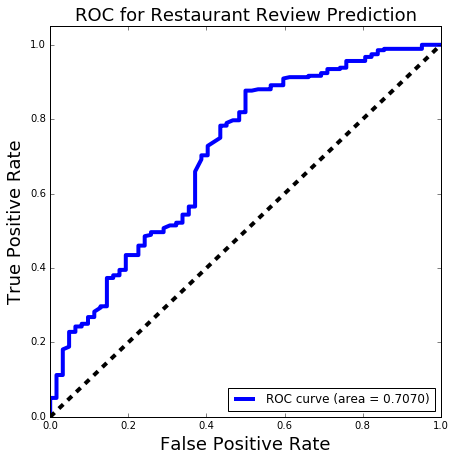

In [75]:
def modelFunc(X, Y): 
    # Perform train-test split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y.values, 
                                                       test_size=0.33, stratify=Y.values,
                                                       random_state=77)

    # run Classification with gridsearch using GridSearchCV and 5 folds
    logreg = LogisticRegression()
    C_vals = [0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
    penalties = ['l1','l2']

    gs = GridSearchCV(logreg, {'penalty':penalties, 'C':C_vals}, verbose=True, cv=5, scoring='f1_macro')
    gs.fit(X_train, Y_train)

    # use this parameter to .fit, .predict, and print a classification_report for our X and Y
    gs_logreg = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty'], solver='liblinear')
    gs_logreg.fit(X_train, Y_train)
    Y_ = gs_logreg.predict(X_test)
    print(classification_report(Y_test, Y_)), "\n"


    # run logistic regression to with the same parameters to predict the probability of being a Positive Review
    logreg = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty'], solver='liblinear')
    logreg.fit(X_train, Y_train)
    # Y_pred = logreg.predict(X_test)
    Y_score = logreg.decision_function(X_test)
    Y_proba_score = logreg.predict_proba(X_test)

    # For class 1, find the area under the curve
    FPR, TPR, thresholds = roc_curve(Y_test, Y_proba_score[:,1])

    ROC_AUC = auc(FPR, TPR)
    print "Area Under the Curve is:", ROC_AUC

    # Plot of a ROC curve for class 1 (positive review)
    plt.figure(figsize=[7,7])
    plt.plot(FPR, TPR, label='ROC curve (area = %0.4f)' % ROC_AUC, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('ROC for Restaurant Review Prediction', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

modelFunc(X,Y)

In [28]:
# Find the Correlation Coefficients and sort by absolute value
# key words are obviously more correlated to the sentiment as expected
a = list(dataDF.columns.values[11:45])
a.extend(['sentiment'])
np.abs(dataDF[a].corr()['sentiment']).sort_values(ascending = False)

sentiment    1.000000
no           0.165527
great        0.159488
bad          0.154418
sad          0.139664
wasn't       0.130677
favorite     0.125847
even         0.120592
never        0.114750
love         0.097814
happy        0.071611
6            0.068731
12           0.066407
good         0.062232
don't        0.060681
1            0.043742
11           0.037511
too          0.037005
3            0.031814
2            0.031688
7            0.028546
2013         0.026162
2014         0.019668
5            0.017333
9            0.017271
2008         0.014826
2010         0.014826
4            0.013903
2015         0.013776
2012         0.008730
8            0.007760
10           0.005559
2011         0.003357
2016         0.001880
like         0.000918
Name: sentiment, dtype: float64

### Option 2: Only use keyword features, excluding year and month
#### model performance deteriorated

In [76]:
# Define feature and responsible variables
Y = dataDF['sentiment']
X = dataDF[dataDF.columns.values[11:25]]

Fitting 5 folds for each of 24 candidates, totalling 120 fits
             precision    recall  f1-score   support

          0       0.76      0.21      0.33        62
          1       0.85      0.99      0.91       276

avg / total       0.83      0.84      0.80       338


Area Under the Curve is: 0.712920757363


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.4s finished


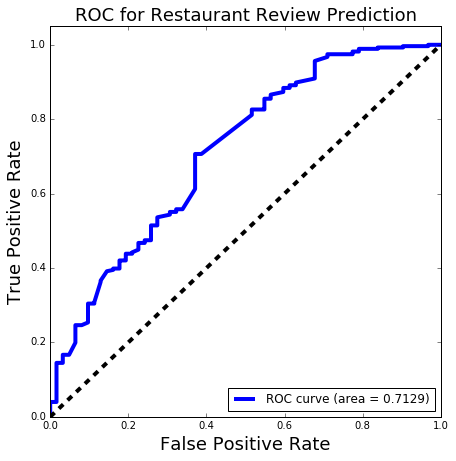

In [77]:
modelFunc(X,Y)

### Option 3: Add more negative keywords as features to increase the recall of negatives

In [31]:
# Add more negative keywords as features
negativesAppend = ['wrong', 'sorry', 'awful', 'didn\'t', 'disappointed', 'however', 'worst', 'terrible', 'slow']
for neg in negativesAppend:
    dataDF[neg] = pd.Series([1 if neg in x.keys() else 0 for x in dataDF['word_counts']], index = dataDF.index)

In [79]:
# Define feature and responsible variables
Y = dataDF['sentiment']
X = dataDF[dataDF.columns.values[11:]]

Fitting 5 folds for each of 24 candidates, totalling 120 fits
             precision    recall  f1-score   support

          0       0.58      0.31      0.40        62
          1       0.86      0.95      0.90       276

avg / total       0.81      0.83      0.81       338


Area Under the Curve is: 0.75087657784


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.1s finished


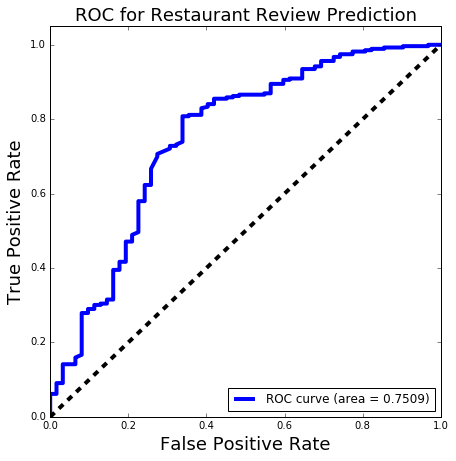

In [80]:
modelFunc(X,Y)

## Best and worst reviews based on our prediction

In [56]:
Y = dataDF['sentiment']
X = dataDF[dataDF.columns.values[11:]]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y.values, 
                                                   test_size=0.33, stratify=Y.values,
                                                   random_state=77)

# run Classification with gridsearch using GridSearchCV and 5 folds
logreg = LogisticRegression()
C_vals = [0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']

gs = GridSearchCV(logreg, {'penalty':penalties, 'C':C_vals}, verbose=True, cv=5, scoring='f1_macro')
gs.fit(X_train, Y_train)

# use this parameter to .fit, .predict, and print a classification_report for our X and Y
gs_logreg = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty'], solver='liblinear')
gs_logreg.fit(X_train, Y_train)
Y_ = gs_logreg.predict(X_test)

# run logistic regression to with the same parameters to predict the probability of being a Positive Review
logreg = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty'], solver='liblinear')
logreg.fit(X_train, Y_train)
# Y_pred = logreg.predict(X_test)
Y_score = logreg.decision_function(X_test)
Y_proba_score = logreg.predict_proba(X_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.6s finished


In [57]:
# Append the predicted score to each row
dataDF['predictedScore'] = pd.Series(logreg.predict_proba(X)[:,1], index = dataDF.index)

In [58]:
dataDF.sort_values(by = 'predictedScore', ascending = False).head(3)

,id,name,url,address,rating,date,review,year,month,sentiment,...,sorry,awful,didn't,disappointed,however,worst,terrible,slow,reviewLength,predictedScore
964,48.0,Japonessa,https://www.yelp.com/biz/japonessa-seattle?hri...,"1400 1st AveSeattle, WA 98101",4.0,2016-10-15,Visiting Seattle and we had to stop in for the...,2016,10,1,...,0,0,0,0,0,0,0,0,0.168367,0.999030
1156,58.0,Umi Sake House,https://www.yelp.com/biz/umi-sake-house-seattl...,"2230 1st AveSeattle, WA 98121",5.0,2016-10-04,Loved this place! Got there right at 4pm when ...,2016,10,1,...,0,0,0,0,0,0,0,0,0.213010,0.998560
882,44.0,Jae’s Asian Bistro & Sushi,https://www.yelp.com/biz/jaes-asian-bistro-and...,"2801 E Madison StSeattle, WA 98112",4.0,2015-12-16,"I enjoy the happy hour often. Rolls, nigiri, ...",2015,12,1,...,0,0,0,0,0,0,0,0,0.058673,0.998454


In [254]:
dataDF.ix[964, 'review']

'Visiting Seattle and we had to stop in for their Happy Hour! We were told it would be a 30-45 min wait, but we were able to get a table in 20 (love it!) Very dim lit ambience. So snapchatting is probably not gonna happen, so just enjoy the meal. I was surprised their Happy hour last almost all day! We ordered the Seattle Crunch Roll, Wicked Sensation Roll, edamame, salmon sashimi, and a Caliente ginger chicken dish. The Seattle Crunch Roll was okay, I felt like the tempura overpowered the rest of the ingredients. We loved the wicked sensation. And the ginger chicken was a pleasant surprise. It had great flavor, but it came with 6 pieces of chips and a buttload of chicken. My favorite - Salmon sashimi. Great seafood in seattle. Thick slabs and it almost melts in your mouth! Would definitely come again!Happy Nomming,Lily'

In [59]:
dataDF.sort_values(by = 'predictedScore', ascending = True).head(3)

,id,name,url,address,rating,date,review,year,month,sentiment,...,sorry,awful,didn't,disappointed,however,worst,terrible,slow,reviewLength,predictedScore
545,28.0,Momoya Sushi & Sake House,https://www.yelp.com/biz/momoya-sushi-and-sake...,"12100 NE 85th StKirkland, WA 98033",1.0,2016-06-11,My worst nightmare came true this evening...no...,2016,6,0,...,0,1,1,0,0,1,1,0,0.176020,0.000220
468,24.0,Tokyo Japanese Steak House,https://www.yelp.com/biz/tokyo-japanese-steak-...,"909 112th Ave NEBellevue, WA 98004",2.0,2016-04-05,"This is a review for my visit on Saturday, Apr...",2016,4,0,...,1,0,1,0,0,1,0,0,0.867347,0.001185
911,46.0,The Bento Box,https://www.yelp.com/biz/the-bento-box-redmond...,"15119 NE 24th StRedmond, WA 98052",1.0,2016-06-07,The worst food in America. Don't go and waste ...,2016,6,0,...,0,0,0,0,0,1,1,0,0.024235,0.002306


In [256]:
dataDF.ix[468, 'review']

'This is a review for my visit on Saturday, April 2!We arrived (two couples, 4 total people) at 8.30Pm and the place was dead. Quiet, one group of four in the back, apparently waiting for us (the only other reservation). This was Saturday night! We thought it\'d be hopping, with a line out the door, or at least some action. It says something when a place known for fire and action was quiet and chilly.I didn\'t catch anyone\'s names - everyone was busy, even our chef. He repeatedly left our grill to grab things, look around, idk. By the time the "show" actually started it, it was about 9.30. And it all felt... staged. Boring. Not fun, but like - I wave my knives around, I start a fire, I go get another spatula because I flung it at that guy, I try again, I go get something, I wave them around again. I could tell that he was more interested in the other people at the table, a group of Koreans. He pretty much did everything for them, and we were just watching him entertain them. He spent 


###  Option 4. Test the Length of Review as a feature to the model

In [50]:
# add the length of review (number of words) for each row
def getReviewLengh(dicty):
    return np.sum([y for (x,y) in dicty.items()])
dataDF['reviewLength'] = pd.Series([getReviewLengh(x) for x in dataDF['word_counts']], index = dataDF.index)

In [86]:
pd.pivot_table(dataDF, index = ['rating'], values = ['reviewLength'], aggfunc = np.mean)

# Try Histogram instead of mean!!!!!

,reviewLength
rating,
1.0,0.127650
2.0,0.172311
4.0,0.147252
5.0,0.122828


In [52]:
# Normalize the reviewLength column

dataDF['reviewLength'] = (dataDF['reviewLength'] - dataDF['reviewLength'].min())/(dataDF['reviewLength'].max() - dataDF['reviewLength'].min())

In [54]:
# dataDF.drop(['reviewLengthNorm'], axis = 1, inplace = True)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
             precision    recall  f1-score   support

          0       0.58      0.31      0.40        62
          1       0.86      0.95      0.90       276

avg / total       0.81      0.83      0.81       338


Area Under the Curve is: 0.750993454885


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.1s finished


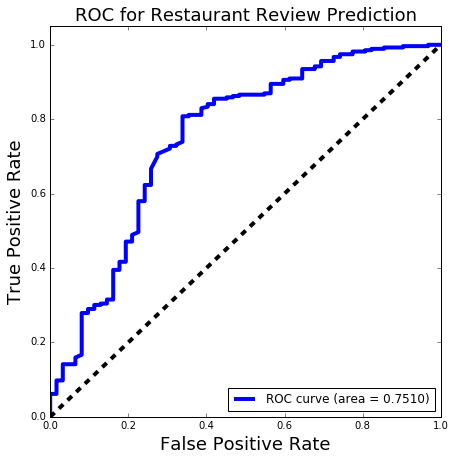

In [82]:
# Define feature and responsible variables
Y = dataDF['sentiment']
X = dataDF[dataDF.columns.values[11:]]
modelFunc(X,Y)

# Limitations of the Bag-of-Word Model:
###  1. Couldn't take into accounts of the combination of words:
#####        e.g. 'only take cash', 'nothing fancy',  'middle grade
#####        e.g. "good" was used in this model as a positive keyword but "Not good" means a negative review

###  2. Assign different weight to keywords
#####       e.g. 'great' indicates a stronger sentiment than 'good'
